# Physics Informed Neural Networks. Para problemas de HCA
Este libro explica brevemente la implementación de una red neuronal para la función de logística y la ecuación de la onda unidimensional.

[Aquí](https://gitlab.com/ldominguezruben/hidrodinamica-de-cuerpos-de-agua-fich-unl/-/blob/master/web/book/notebooks/ref/PINNs.pdf?ref_type=heads) se encuentra la presentación de clase.

**Basado en tutorial de:** Filippo Maria Bianchi.

**Información adicional de [N-S](https://github.com/hojunkim13/PINNs/tree/main/Navier-Stokes)**

## Redes neuronales

In [1]:
# Librerias
import torch
from torch import nn
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from matplotlib import cm

ModuleNotFoundError: No module named 'torch'

Iniciamos creando una red neuronal usando <a href="https://pytorch.org"><b>PyTorch</b></a>.

In [26]:
# Define a simple neural network for regression
class simple_NN(nn.Module):
    def __init__(self):
        # Inicializa la clase base 'nn.Module' para construir la red neuronal
        super(simple_NN, self).__init__()
        
        # Definir una secuencia de capas en la red neuronal usando nn.Sequential
        # La red tiene cuatro capas lineales con funciones de activación Tanh entre ellas
        self.linear_tanh_stack = nn.Sequential(
            nn.Linear(1, 16),   # Capa de entrada, de 1 a 16 neuronas
            nn.Tanh(),          # Función de activación Tanh
            nn.Linear(16, 32),  # Capa de 16 a 32 neuronas
            nn.Tanh(),          # Función de activación Tanh
            nn.Linear(32, 16),  # Capa de 32 a 16 neuronas
            nn.Tanh(),          # Función de activación Tanh
            nn.Linear(16, 1),   # Capa de salida, de 16 a 1 neurona 
        )

    def forward(self, x):
        # Define el paso hacia adelante (forward pass) de la red
        # El input 'x' pasa a través de las capas definidas anteriormente
        out = self.linear_tanh_stack(x)
        return out

- Creamos una NN para predecir: $\hat{y}_i = \rm{NN}(x_i)$.
- Base de datos $\{x_i, y_i\}_{i=1, \dots ,5}$.

In [27]:
# Construimos una base de datos (en base a los datos medidos en el experimento)
x_train = torch.tensor([[1.1437e-04],
        [1.4676e-01],
        [3.0233e-01],
        [4.1702e-01],
        [7.2032e-01]], dtype=torch.float32)

y_train = torch.tensor([[1.0000],
        [1.0141],
        [1.0456],
        [1.0753],
        [1.1565]], dtype=torch.float32)

- Entrenamos el modelo para minimizar el error $\rm{MSE}(\boldsymbol{y}, \boldsymbol{\hat{y}})$.

In [28]:
# Initialize the model
model = simple_NN()  # Red neuronal simple para regresión

# Definimos la función de pérdida
loss_fn = nn.MSELoss()  # Función de pérdida de error cuadrático medio (MSE), comúnmente utilizada para regresión

# Inicializamos el optimizador Adam
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)  # Adam es un optimizador eficiente para el entrenamiento de redes neuronales

# Entrenamos el modelo durante 1000 épocas
for ep in range(1000):  # Usamos 1000 épocas para entrenar la red. Eso se puede cambiar (lo vemos)
    # Calcular la predicción y el error
    pred = model(x_train)  # Realiza una predicción pasando x_train a través del modelo
    loss = loss_fn(pred, y_train)  # Calcula la pérdida (error) entre la predicción y las etiquetas verdaderas (y_train)

    # Retropropagación del error
    optimizer.zero_grad()  # Restablece los gradientes acumulados de la iteración anterior
    loss.backward()  # Calcula los gradientes de la pérdida con respecto a los parámetros del modelo
    optimizer.step()  # Actualiza los parámetros del modelo utilizando los gradientes calculados

    # Imprimir el progreso cada 200 épocas
    if ep % 200 == 0:
        print(f"epoch: {ep}, loss: {loss.item():>7f}")  # Muestra la pérdida actual cada 200 épocas

epoch: 0, loss: 1.295078
epoch: 200, loss: 0.000271
epoch: 400, loss: 0.000161
epoch: 600, loss: 0.000046
epoch: 800, loss: 0.000005


Evaluamos el modelo NN

In [29]:
# donde evaluamos
domain = [0.0, 1.5]
# Genera una secuencia de 100 puntos igualmente distribuidos en el dominio
x_eval = torch.linspace(domain[0], domain[1], steps=100).reshape(-1, 1)

# Evalúa el modelo sobre esos puntos generando las predicciones
f_eval = model(x_eval)

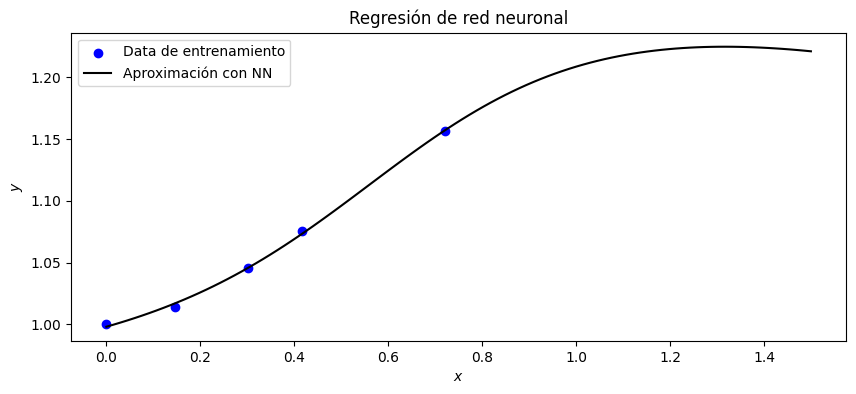

In [30]:
# plotting
fig, ax = plt.subplots(figsize=(10, 4))
ax.scatter(x_train.detach().numpy(), y_train.detach().numpy(), label="Data de entrenamiento", color="blue")
ax.plot(x_eval.detach().numpy(), f_eval.detach().numpy(), label="Aproximación con NN", color="black")
ax.set(title="Regresión de red neuronal", xlabel="$x$", ylabel="$y$")
ax.legend();

La red neuronal da un buen ajuste referidos a los datos experimentales. Sin embargo no tenemos datos por encima de $x>0.8$ 

## Physics Informed NNs

- Ahora usemos las PDEs para ajustar nuestra red.
- Entrenamos el modelo con funciones de perdidas adicionales para penalizarlo (basado en PDE).

$$ \mathcal{L}_{\text{tot}} =  \mathcal{L}_{\text{data}} + \mathcal{L}_{\text{PDE}}$$


**Ventajas**

Puede combinar información relevada y modelos físicos .
- Comparado con una red neuronal tradicional, $\mathcal{L}_{\text{PDE}}$ regulariza el modelo limitando el overfitting (sobre ajuste) y mejora la generalización improving generalization.
- Comparado con un método de resolución clásico de PDE es mejor escalable las PINNs

### Ejemplo I: Ecuación de logística (Introducción al caos. Turbulencia)

Ecuación general de logística

$$ \frac{d f(t)}{d t} = Rt(1-t)$$

- $f(t)$ es el crecimiento de población a la tasa $t$.
- $R$ es la máxima tasa de crecimiento.

- La ecuación de logística tiene infinitas soluciones (bifurcaciones) 
- Para identificar una solución imponemos una condición de borde a $t=0$:

$$f(t=0)=1$$

In [31]:
#Condicionamiento a la ecuación de logística
R = 1.0 #tasa de crecimiento
ft0 = 1.0 #solución

- Modelamos la $f(t)$ con la NN i.e., $$f(t) = \rm{NN}(t)$$
- Facilmente computamos la derivada gracias a la librerías de DEEP LEARNING $\frac{d\rm{NN}(t)}{dt}$.


In [32]:
def df(f: simple_NN, x: torch.Tensor = None, order: int = 1) -> torch.Tensor:
    """Compute neural network derivative with respect to input features 
    using PyTorch autograd engine"""
    
    df_value = f(x)
    for _ in range(order):
        df_value = torch.autograd.grad(
            df_value,
            x,
            grad_outputs=torch.ones_like(x), # what is this?
            create_graph=True,
            retain_graph=True,
        )[0]

    return df_value 

En nuestro caso, la NN debe satisfacer la siguiente ecuación:

$$ \frac{d\rm{NN}(t)}{dt} - Rt(1-t) = 0 $$

Introducimos una función de regularización (en base a la PDE):
$$ \mathcal{L}_{PDE} = \frac{1}{N} \sum_{i=1}^N \left( \frac{d \rm{NN}} {dt} \bigg\rvert_{t_i} - R t_i (1-t_i) \right)^2$$

donde $t_i$ are posición de puntos del dominio que serán evaluados.

In [33]:
#Generamos 10 puntos espaciados
t = torch.linspace(domain[0], domain[1], steps=10, requires_grad=True).reshape(-1, 1)

- Minimizando solo $\mathcal{L}_{PDE}$ no garantiza una unica solución.
- Debemos incluir las condiciones de borde:

$$ \mathcal{L}_{BC} = \left( \rm{NN}(t_0) - 1 \right)^2 $$

Esto permite que la red neuronal (NN) converja a la solución deseada entre las infinitas posibles.

La función de perdida total es:

$$ \mathcal{L}_{PDE} + \mathcal{L}_{BC} + \mathcal{L}_{data} $$

In [34]:
# Definimos una función para calcular la pérdida total del modelo
def compute_loss(nn: simple_NN,  # Red neuronal que aproxima la solución de la PDE
                 t: torch.Tensor = None,  # Tensor para la variable independiente t (por ejemplo, tiempo)
                 x: torch.Tensor = None,  # Tensor de entrada para datos observados (opcional)
                 y: torch.Tensor = None,  # Tensor de salida asociada a x (opcional)
                 ) -> torch.float:  # Devuelve un escalar de tipo float para la pérdida total
    """
    Calcula la función de pérdida total como la suma de la pérdida de la PDE,
    la pérdida de las condiciones de frontera y el error con datos observados (si los tiene).
    
    Esta función de pérdida es totalmente diferenciable, lo que permite usar el método .backward()
    para calcular los gradientes.
    """
    
    # Cálculo del residuo de la PDE
    pde_loss = df(nn, t) - R * t * (1 - t)  # Diferencia entre la derivada calculada y el término físico esperado
    pde_loss = pde_loss.pow(2).mean()  # Eleva al cuadrado para penalizar errores positivos y negativos de manera uniforme,
                                       # y toma el promedio para obtener un escalar representativo

    # Cálculo de la pérdida asociada a las condiciones de frontera (Boundary Condition - BC)
    boundary = torch.Tensor([0.0])  # Valor específico para la condición de frontera (en este caso t = 0)
    boundary.requires_grad = True  # Se habilita el cálculo de gradientes en este tensor
    bc_loss = nn(boundary) - ft0  # Error entre la predicción de la red en el límite y el valor esperado (ft0)
    bc_loss = bc_loss.pow(2)  # Penaliza errores elevados en la condición de frontera

    # Cálculo de la pérdida de mínimos cuadrados medios (MSE) con datos observados
    mse_loss = torch.nn.MSELoss()(nn(x), y)  # Compara las predicciones de la red con datos reales (x, y)

    # Suma de todas las componentes de pérdida para obtener la pérdida total
    tot_loss = pde_loss + bc_loss + mse_loss

    return tot_loss  # Devuelve el valor total de la pérdida

In [35]:
# Inicializamos el modelo
model = simple_NN()  # Instancia de la red neuronal que se utilizará para aproximar la solución

# Configuramos el optimizador
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)  
# Adam es un optimizador basado en gradientes que adapta las tasas de aprendizaje individuales
# model.parameters() indica los parámetros del modelo que se van a actualizar
# lr=1e-2 establece la tasa de aprendizaje inicial como 0.01

# Entrenamiento del modelo
for ep in range(2000):  # Iteramos durante 2000 épocas

    # Calculamos la pérdida total (combinación de pde_loss, boundary_loss y mse_loss)
    loss = compute_loss(model, t, x_train, y_train)  
    # `t`: variable independiente (por ejemplo, tiempo)
    # `x_train` y `y_train`: datos observados para el entrenamiento (opcional según el problema)

    # Retropropagación
    optimizer.zero_grad()  # Resetea los gradientes acumulados de iteraciones anteriores
    loss.backward()  # Calcula los gradientes de la pérdida con respecto a los parámetros del modelo
    optimizer.step()  # Actualiza los parámetros del modelo utilizando los gradientes calculados

    # Mostramos el progreso cada 200 épocas
    if ep % 200 == 0:
        print(f"epoch: {ep}, loss: {loss.item():>7f}")  
        # `loss.item()` extrae el valor escalar de la pérdida para imprimirlo

epoch: 0, loss: 2.810295
epoch: 200, loss: 0.000703
epoch: 400, loss: 0.000152
epoch: 600, loss: 0.000101
epoch: 800, loss: 0.000091
epoch: 1000, loss: 0.000088
epoch: 1200, loss: 0.000087
epoch: 1400, loss: 0.000086
epoch: 1600, loss: 0.000085
epoch: 1800, loss: 0.000084


In [36]:
# Solución numérica
def logistic_eq_fn(x, y):
    """
    Define la ecuación diferencial logística.
    Esta es una función que describe el cambio de una población en función de su tamaño 
    y de la tasa de crecimiento en el modelo logístico.

    Parámetros:
    - x: valor independiente (por ejemplo, el tiempo o el espacio).
    - y: valor dependiente (por ejemplo, la población en un momento dado).

    Retorna:
    - La tasa de cambio de y con respecto a x, usando la fórmula de la ecuación logística.
    """
    return R * x * (1 - x)  # Modelo logístico con una tasa de crecimiento R

# Resolver la ecuación diferencial utilizando el solver 'solve_ivp'
numeric_solution = solve_ivp(
    logistic_eq_fn,              # Función que define la ecuación diferencial
    domain,                       # Dominio sobre el cual se evalúa la solución
    [ft0],                        # Condición inicial en t=0
    t_eval=x_eval.squeeze().detach().numpy()  # Puntos de tiempo donde evaluar la solución
)

# Resolver la ecuación diferencial para obtener la solución en 't'
f_colloc = solve_ivp(
    logistic_eq_fn,              # Función que define la ecuación diferencial
    domain,                       # Dominio de la solución
    [ft0],                        # Condición inicial en t=0
    t_eval=t.squeeze().detach().numpy()  # Puntos de tiempo donde evaluar la solución
).y.T  # Transponemos el resultado para tener la forma correcta

Evaluamos en un entorno extendido de la data de muestreo $[0, 1.5]$

In [37]:
f_PINN_eval = model(x_eval)

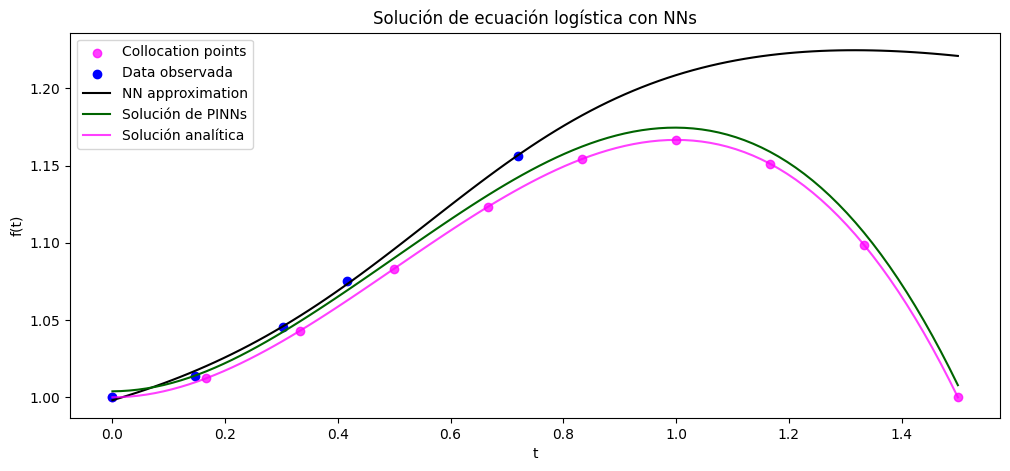

In [38]:
# plotting
fig, ax = plt.subplots(figsize=(12, 5))
ax.scatter(t.detach().numpy(), f_colloc, label="Collocation points", color="magenta", alpha=0.75)
ax.scatter(x_train.detach().numpy(), y_train.detach().numpy(), label="Data observada", color="blue")
ax.plot(x_eval.detach().numpy(), f_eval.detach().numpy(), label="NN approximation", color="black")
ax.plot(x_eval.detach().numpy(), f_PINN_eval.detach().numpy(), label="Solución de PINNs", color="darkgreen")
ax.plot(x_eval.detach().numpy(), numeric_solution.y.T,
        label="Solución analítica", color="magenta", alpha=0.75)
ax.set(title="Solución de ecuación logística con NNs", xlabel="t", ylabel="f(t)")
ax.legend();

## Ejemplo II: 1d wave

- Ahora trabajamos nuestra NN para aprender de una función  $f(x,t)$ de $2^{nd}$ orden PDE:
$$\frac{\partial^2 f}{\partial x^2} -  \frac{1}{C} \frac{\partial^2 f}{\partial t^2}= 0$$ 
Donde $C$ es un valor positivo.

- $f$ depende de dos variables: 
    - espacio ($x$),
    - tiempo ($t$).
- Modificamos nuestra red neuronal para que acepte esto .

In [39]:
# Definición de la clase para la red neuronal
class simple_NN2(nn.Module):  
    def __init__(self):  
        # Llama al constructor de la clase base nn.Module
        super(simple_NN2, self).__init__()  
        
        # Define una pila secuencial de capas lineales (3)y funciones de activación Tanh
        self.linear_tanh_stack = nn.Sequential(  
            nn.Linear(2, 16),    # Primera capa: toma 2 variables de entrada y produce 16 salidas
            nn.Tanh(),           # Función de activación Tanh, para no linealidad
            nn.Linear(16, 32),   # Segunda capa: toma 16 entradas y produce 32 salidas
            nn.Tanh(),           # Otra función de activación Tanh
            nn.Linear(32, 16),   # Tercera capa: toma 32 entradas y produce 16 salidas
            nn.Tanh(),           # Función de activación
            nn.Linear(16, 1),    # Capa final: toma 16 entradas y produce una única salida
        )

    def forward(self, x, t):  
        """
        Método forward: define el flujo de datos en la red.
        """
        # Combina las variables x y t en un solo tensor concatenándolas por columnas (dim=1)
        x_stack = torch.cat([x, t], dim=1)  
        
        # Pasa el tensor combinado por la pila de capas lineales y activaciones
        out = self.linear_tanh_stack(x_stack)  
        
        return out  # Devuelve la salida

- La función que definimos previamente, `df()`, computamos las derivadas de cualquier orden respecto a una sola variable .
- Ahora lo modificamos para que sea diferenciable a ambas variables  $x$ and $t$.

In [40]:
def df(output: torch.Tensor, input_var: torch.Tensor, order: int = 1) -> torch.Tensor:
    """
    Compute neural network derivative with respect to input features 
    using PyTorch autograd engine.

    Parameters:
    - output: La salida del modelo neural que será diferenciada.
    - input_var: La variable de entrada con respecto a la cual se calcularán las derivadas.
    - order: El orden de la derivada (por defecto, es 1).
    
    Returns:
    - df_value: La derivada de la salida respecto a la variable de entrada.
    """
    
    df_value = output  # Asignamos directamente la salida inicial del modelo como punto de partida
    for _ in range(order):  # Repetimos el cálculo tantas veces como sea el orden de la derivada
        df_value = torch.autograd.grad(
            df_value,                 # La salida del paso anterior
            input_var,                # Variable de entrada con respecto a la cual derivar
            grad_outputs=torch.ones_like(input_var),  # Gradiente inicializado en unos
            create_graph=True,        # Permite la creación de un grafo computacional para derivadas sucesivas
            retain_graph=True,        # Conserva el grafo existente para cálculos adicionales
        )[0]  # Seleccionamos el tensor resultante de la derivada
    return df_value

In [41]:
def dfdt(model: simple_NN2, x: torch.Tensor, t: torch.Tensor, order: int = 1):
    """Derivative with respect to the time variable of arbitrary order"""
    
    f_value = model(x, t)
    return df(f_value, t, order=order) # <--- derivative wrt t

In [42]:
def dfdx(model: simple_NN2, x: torch.Tensor, t: torch.Tensor, order: int = 1):
    """Derivative with respect to the spatial variable of arbitrary order"""
    
    f_value = model(x, t)
    return df(f_value, x, order=order) # <--- derivative wrt x

#### Función de perdida 

- No consideramos la información de relevamiento 
- Entrenamos al modelo NN con la ecuación física 
- El primer término de la función de pérdida fomenta el cumplimiento de la ecuación de ondas unidimensional, que generalmente se expresa como:

$$\mathcal{L}_{PDE} = \left( \frac{\partial^2 f}{\partial x^2} - \frac{1}{C} \frac{\partial^2 f}{\partial t^2} \right)^2 $$

- Restringimos la solución d ela siguiente manera:
* 1. Imponemos una condición periódica en los extremos del dominio.
* 2. Imponemos una condición inicial  $f(x, t_0)$.
* 3. Imponemos una condición inicial para  $\frac{\partial f(x, t)}{\partial t} \bigg\rvert_{t=0}$.

- Definimos el dominio. en este caso $x_0 = 0$ and $x_1 = 1$.

- Imponemos una penalización a la condición de borde:

$$\mathcal{L}_{BC} = f(x_0, t)^2 + f(x_1, t)^2$$

- Definimos la condición inicial $f(x, t_0)=\frac{1}{2} \rm{sin}(2\pi x)$.

- Definimos la penalizamos a la primer condición inicial (definida previamente):

$$\mathcal{L}_{initF} = \left( f(x, t_0) - \frac{1}{2} \rm{sin}(2\pi x) \right)^2 $$

- Finalmente especificamos la condición inicial  $\frac{\partial f(x, t)}{\partial t} \bigg\rvert_{t=0}=0$.

También penalizamos la segundo condición inicial:

$$\mathcal{L}_{initDF} = \left( \frac{\partial f}{\partial t} \bigg\rvert_{t=0} \right)^2 $$

La función de perdida total sería:

$$\mathcal{L}_{PDE} + \mathcal{L}_{BC} + \mathcal{L}_{initF} + \mathcal{L}_{initDF}$$

In [43]:
def initial_condition(x) -> torch.Tensor:
    """
    Define la condición inicial para el problema.

    Parámetros:
    - x: Tensor que representa las posiciones espaciales.

    Retorna:
    - res: Tensor con los valores iniciales, definidos como 0.5 * sin(2πx).

    Descripción:
    - La función aplica una función seno a las posiciones espaciales `x`, 
      escalándola por un factor de 0.5. 
    - La forma de salida se ajusta con `.reshape(-1, 1)` para asegurar 
      que tenga una dimensión adicional compatible con otras operaciones.
    """
    res = torch.sin(2 * np.pi * x).reshape(-1, 1) * 0.5
    return res

In [44]:
# Función para calcular la pérdida total
def compute_loss(
    model: simple_NN2,  # Modelo que aproxima la solución de la PDE
    x: torch.Tensor = None,  # Tensor para la variable espacial x
    t: torch.Tensor = None,  # Tensor para la variable temporal t
    x_idx: torch.Tensor = None,  # Puntos discretos en x para condiciones iniciales y de frontera
    t_idx: torch.Tensor = None,  # Puntos discretos en t para condiciones de frontera
    C: float = 1.0,  # Velocidad de propagación (constante de la PDE)
    device: str = None  # Dispositivo para ejecutar los cálculos (CPU o GPU)
) -> torch.float:  # Retorna un escalar que representa la pérdida total

    # **1. Pérdida de la PDE**
    # Calcula el residuo de la PDE que queremos que el modelo satisfaga
    # PDE: d²f/dx² - (1/C²) * d²f/dt² = 0
    pde_loss = dfdx(model, x, t, order=2) - (1 / C**2) * dfdt(model, x, t, order=2)
    # `dfdx` y `dfdt` son funciones que calculan derivadas de segundo orden respecto a x y t.

    # **2. Condiciones de frontera (boundary conditions)**
    # f(x0, t): Evaluar la frontera izquierda en x = x[0]
    boundary_x0 = torch.ones_like(t_idx, requires_grad=True).to(device) * x[0]
    boundary_loss_x0 = model(boundary_x0, t_idx)  # f(x0, t)

    # f(x1, t): Evaluar la frontera derecha en x = x[-1]
    boundary_x1 = torch.ones_like(t_idx, requires_grad=True).to(device) * x[-1]
    boundary_loss_x1 = model(boundary_x1, t_idx)  # f(x1, t)

    # **3. Condiciones iniciales (initial conditions)**
    # f(x, t0): Evaluar en t = 0 para condiciones iniciales
    f_initial = initial_condition(x_idx)  # Función definida, por ejemplo, 0.5 * sin(2πx)
    t_initial = torch.zeros_like(x_idx)  # t = 0 para todos los puntos en x
    t_initial.requires_grad = True  # Habilitamos gradientes en t = 0
    initial_loss_f = model(x_idx, t_initial) - f_initial  # Error entre modelo y condición inicial

    # df/dt(x, t0): Derivada temporal inicial en t = 0
    initial_loss_df = dfdt(model, x_idx, t_initial, order=1)  # Error en derivada inicial

    # **4. Pérdida final**
    # Promediamos y sumamos las contribuciones de todas las pérdidas
    final_loss = (pde_loss.pow(2).mean() + # Penalización por no cumplir la PDE
                  boundary_loss_x0.pow(2).mean() + # Penalización en frontera x = x[0]
                  boundary_loss_x1.pow(2).mean() + # Penalización en frontera x = x[-1]
                  initial_loss_f.pow(2).mean() + # Penalización en condición inicial f(x, t0)
                  initial_loss_df.pow(2).mean()) # Penalización en derivada inicial df/dt(x, t0)

    return final_loss  # Devuelve la pérdida total


In [45]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# generate the time-space meshgrid
x_domain = [0.0, 1.0]; n_points_x = 100
t_domain = [0.0, 1.0]; n_points_t = 150
x_idx = torch.linspace(x_domain[0], x_domain[1], steps=n_points_x, requires_grad=True)
t_idx = torch.linspace(t_domain[0], t_domain[1], steps=n_points_t, requires_grad=True)
grids = torch.meshgrid(x_idx, t_idx, indexing="ij")
x_idx, t_idx = x_idx.reshape(-1, 1).to(device), t_idx.reshape(-1, 1).to(device)
x, t = grids[0].flatten().reshape(-1, 1).to(device), grids[1].flatten().reshape(-1, 1).to(device)

# initialize the neural network model
model = simple_NN2().to(device)

In [46]:
# Train
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
for ep in range(2000):

    loss = compute_loss(model, x=x, t=t, x_idx=x_idx, t_idx=t_idx, device=device)

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if ep % 300 == 0:
        print(f"epoch: {ep}, loss: {loss.item():>7f}")

epoch: 0, loss: 0.155638
epoch: 300, loss: 0.047501
epoch: 600, loss: 0.028385
epoch: 900, loss: 0.022591
epoch: 1200, loss: 0.012427
epoch: 1500, loss: 0.024755
epoch: 1800, loss: 0.002670
epoch: 2100, loss: 0.004129
epoch: 2400, loss: 0.001357
epoch: 2700, loss: 0.003822


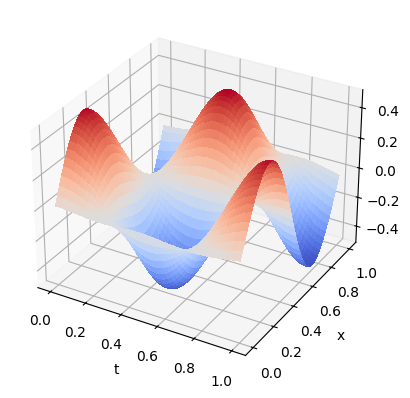

In [47]:
# Prediction
y = model(x, t)
y_np = y.reshape([100,-1]).to("cpu").detach().numpy()

# Plot
X, Y = np.meshgrid(np.linspace(0, 1, 150), np.linspace(0, 1, 100))
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(X, Y, y_np, linewidth=0, antialiased=False, cmap=cm.coolwarm,)
ax.set_xlabel("t"), ax.set_ylabel("x"), ax.set_zlabel("f")
plt.show();

## References

[[1](https://www.sciencedirect.com/science/article/pii/S0021999118307125)] Raissi, Maziar, Paris Perdikaris, and George E. Karniadakis. "Physics-informed neural networks: A deep learning framework for solving forward and inverse problems involving nonlinear partial differential equations." Journal of Computational physics 378 (2019): 686-707.

[[2](https://maziarraissi.github.io/PINNs/)] Raissi, Maziar, Paris Perdikaris, and George E. Karniadakis. "Physics Informed Deep Learning".

[[3](https://www.sciencedirect.com/science/article/pii/S095219762030292X)] Nascimento, R. G., Fricke, K., & Viana, F. A. (2020). A tutorial on solving ordinary differential equations using Python and hybrid physics-informed neural network. Engineering Applications of Artificial Intelligence, 96, 103996.

[[4](https://towardsdatascience.com/solving-differential-equations-with-neural-networks-afdcf7b8bcc4)] Dagrada, Dario. "Introduction to Physics-informed Neural Networks" ([code](https://github.com/madagra/basic-pinn)).

[[5](https://towardsdatascience.com/physics-and-artificial-intelligence-introduction-to-physics-informed-neural-networks-24548438f2d5)] Paialunga Piero. "Physics and Artificial Intelligence: Introduction to Physics Informed Neural Networks".

[[6](https://github.com/omniscientoctopus/Physics-Informed-Neural-Networks)] "Physics-Informed-Neural-Networks (PINNs)" - implementation of PINNs in TensorFlow 2 and PyTorch for the Burgers' and Helmholtz PDE.